<a href="https://colab.research.google.com/github/DimpleDR/Computational-Data-Science/blob/Projects/M6_SNB_MiniProject_3_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Video Classification using LSTM

**DISCLAIMER:** THIS NOTEBOOK IS PROVIDED ONLY AS A REFERENCE SOLUTION NOTEBOOK FOR THE MINI-PROJECT. THERE MAY BE OTHER POSSIBLE APPROACHES/METHODS TO ACHIEVE THE SAME RESULTS.

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features of the video frames
* train the LSTM, GRU model to classify the video based on sequence

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:



*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:**

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN;
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file;
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability;
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video.




## Grading = 10 Points

### Install and re-start the runtime

In [ ]:
!pip3 install imageio==2.4.1

In [1]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
!unzip -qq Actions.zip
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import Required packages

In [2]:
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
#from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

import os, glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [3]:
data_dir = "/content/Actions/train/"
img_height , img_width = 160, 120
n_channels = 3
seq_len = 20
classes = os.listdir(data_dir)
classes

['boxing', 'running', 'jogging', 'Walking', 'handwaving', 'Handclapping']

In [4]:
# Creating frames from videos; selecting the frames from the middle of video
def frames_extraction(video_path):
    frames_list = []
    vidObj = cv2.VideoCapture(video_path)
    frames = vidObj.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = int(vidObj.get(cv2.CAP_PROP_FPS))
    seconds = int(frames / fps)
    frame_count = 0
    frame_seq = 0
    while frame_count < frames:
        success, image = vidObj.read()
        if success and frame_count == int(frames * frame_seq):
            image = cv2.resize(image, (img_width, img_height))
            frames_list.append(image)
            frame_seq += 1 / seq_len
        elif not success:
            print("Defected frame")
            break
        frame_count += 1

    return frames_list, fps, seconds

In [5]:
# selecting first frames
def frames_extraction(video_path):
    frames_list = []
    vidObj = cv2.VideoCapture(video_path)
    frames = vidObj.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = int(vidObj.get(cv2.CAP_PROP_FPS))
    seconds = int(frames / fps)
    frame_count = 1
    while frame_count <= seq_len:
        success, image = vidObj.read()
        if success:
            image = cv2.resize(image, (img_width, img_height))
            frames_list.append(image)
        elif not success:
            print("Defected frame")
            break
        frame_count += 1

    return frames_list, fps, seconds

In [6]:
# testing with 1 sample of video
vid = frames_extraction("/content/Actions/train/Handclapping/person01_handclapping_d3_uncomp.avi")
np.array(vid[0]).shape, vid[1], vid[2]

((20, 160, 120, 3), 25, 17)

generating frames of all the videos and storing it in numpy array

In [7]:
def create_data(input_dir):
    X, Y, fps_list, duration = [], [], [], []
    classes_list = os.listdir(input_dir)
    for c in classes_list:
      print(c)
      files_list = os.listdir(os.path.join(input_dir, c))
      for f in files_list:
        frames, fps, sec_s = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
        fps_list.append(fps)
        duration.append(sec_s)
        if len(frames) == seq_len:
          X.append(frames)
          Y.append(c)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y,fps_list, duration

X, label, fps_list, duration = create_data(data_dir)

boxing
running
jogging
Walking
handwaving
Handclapping


In [8]:
X.shape, label.shape

((479, 20, 160, 120, 3), (479,))

In [9]:
# fps is common for all the videos
set(fps_list)

{25}

In [10]:
# different duration for videos
print(set(duration))

{8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 41, 42, 44}


In [11]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(label)
y = le.transform(label)
# one hot encoding Classes
Y = to_categorical(y)
Y.shape

(479, 6)

#### Load Test data

In [12]:
test_data_dir = "/content/Actions/test/"
Xtest, Ytest, _, _ = create_data(test_data_dir)

boxing
running
jogging
Walking
handwaving
Handclapping


In [13]:
ytest = le.transform(Ytest)

Ytest = to_categorical(ytest)
Ytest.shape

(120, 6)

In [14]:
np.where(label==classes[3])

(array([240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
        253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
        266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278,
        279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291,
        292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304,
        305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
        318, 319]),)

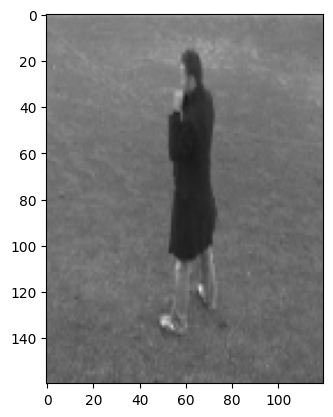

In [15]:
plt.imshow(X[0][0])

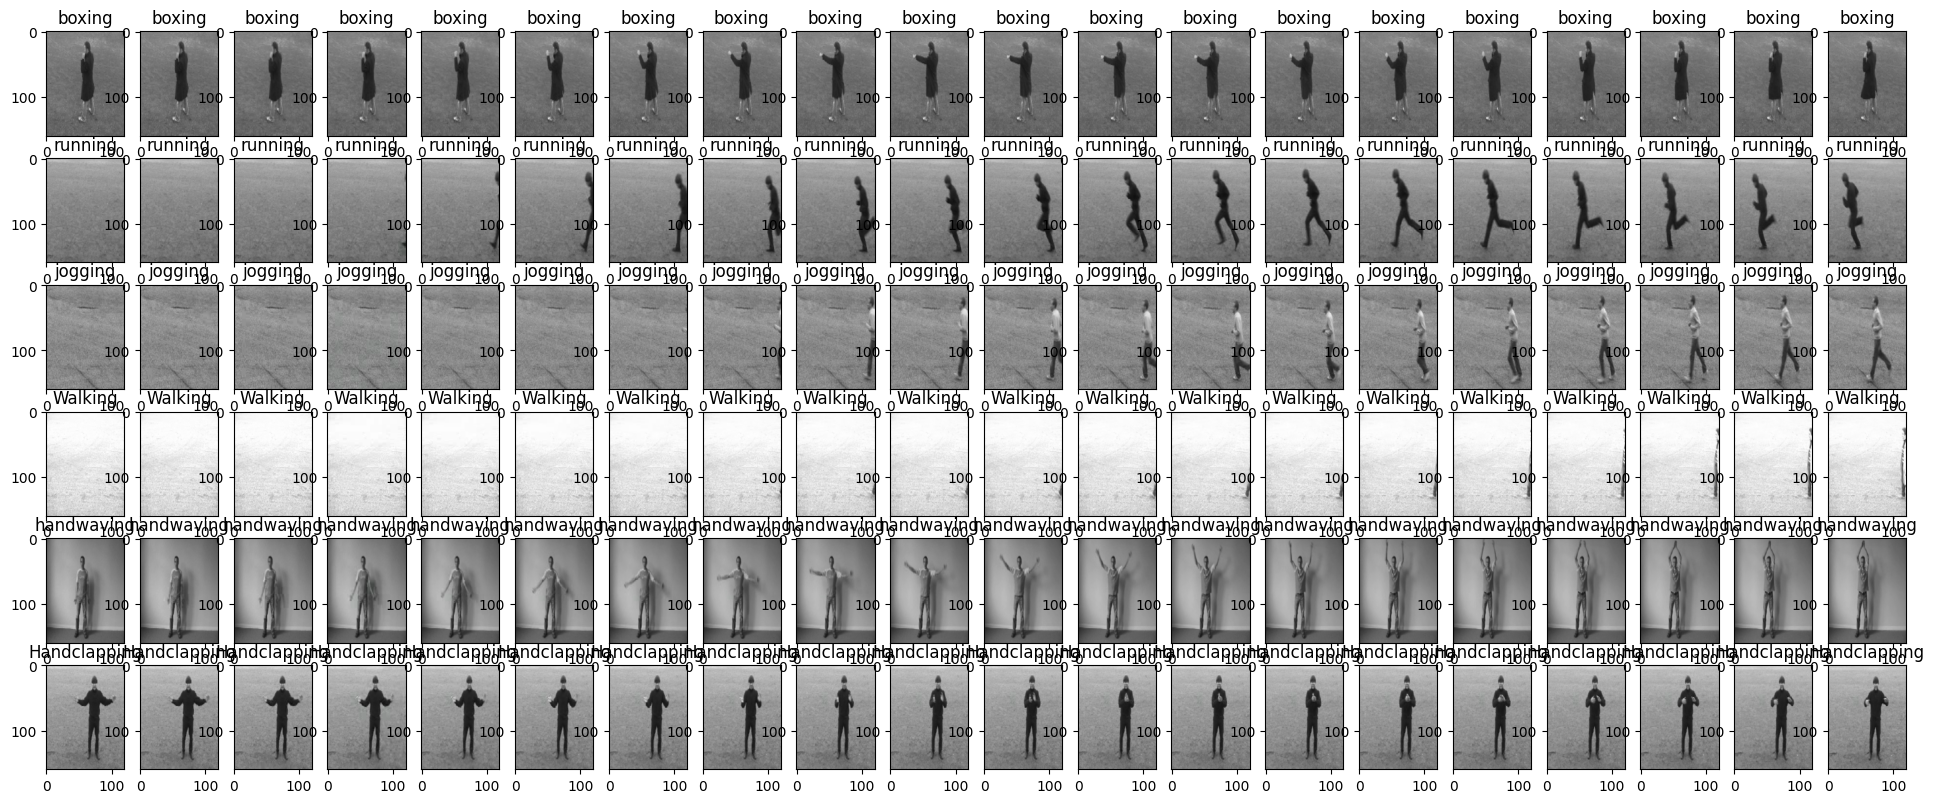

In [16]:
fig = plt.figure(figsize=(seq_len * img_width / 100, len(classes)*img_height/100))
columns = seq_len
rows = 6
counter = 1
for i in list(range(len(label)))[::83]:
  for j in range(seq_len):
    fig.add_subplot(rows, columns, counter)
    counter += 1
    plt.imshow(X[i][j])
    plt.title(label[i])
plt.show()

In [17]:
# to play the video and to observe the ACTION in frames
from moviepy.editor import *
path="/content/Actions/train/Walking/person11_walking_d4_uncomp.avi"

clip=VideoFileClip(path)
ipython_display(clip,width=280)

  if event.key is 'enter':



Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### Create the neural network

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat time series.
* Apply a DenseNet to take the decision, to classify.

##### Build the ConvNet for the feature extraction

In [18]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D

def build_convnet(shape=(160, 120, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape, activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Conv2D(512, (3,3), activation='relu'))
    model.add(BatchNormalization())

    # flatten...
    # You can also use Flatten but GlobalMaxPool2D will reduce the number of outputs (getting only maximum values from the last convolution)
    model.add(GlobalMaxPool2D())
    return model

#### Build the Time Distributed model and DenseNet

In [19]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout

def action_model(shape=(40, 160, 120, 3), nbout=6):
    # Create our convnet with (160, 120, 3) input shape
    convnet = build_convnet(shape[1:]) # Removes the '40' dimension index

    # then create our final model
    model = Sequential()

    # add the convnet with (5, 160, 120, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))

    # here, you can also use GRU or LSTM
    model.add(GRU(64))

    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

#### Setup the parameters and train the model with epochs in batch wise

In [20]:
INSHAPE = (seq_len,) + (img_height,img_width) + (n_channels,) # (5, 160, 120, 3)
print(INSHAPE, len(classes))
model = action_model(INSHAPE, len(classes))
optimizer = Adam(0.00001)
model.compile(optimizer, 'categorical_crossentropy', metrics=['acc'])

  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



(20, 160, 120, 3) 6


  super().__init__(**kwargs)



In [21]:
model.fit(x = X, y = Y, validation_data=(Xtest, Ytest), epochs=10, batch_size = 10)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1000ms/step - acc: 0.2084 - loss: 1.8600 - val_acc: 0.1667 - val_loss: 1.8012
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 909ms/step - acc: 0.1965 - loss: 1.8120 - val_acc: 0.2083 - val_loss: 1.7869
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 915ms/step - acc: 0.2010 - loss: 1.8370 - val_acc: 0.2167 - val_loss: 1.7747
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 84s 967ms/step - acc: 0.2075 - loss: 1.8052 - val_acc: 0.2417 - val_loss: 1.7639
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 969ms/step - acc: 0.1741 - loss: 1.8239 - val_acc: 0.2917 - val_loss: 1.7537
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 918ms/step - acc: 0.2169 - loss: 1.8162 - val_acc: 0.2917 - val_loss: 1.7512
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 920ms/step - acc: 0.1557 - loss: 1.7947 - val_acc: 0.3083 - val_loss: 1.7355
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 919ms/step - acc: 0.2210 - loss: 1.7957 - val_acc: 0.3417 - val_loss: 1.7212
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 929ms

#### Model 2

Model 2 with Time Distributed layers of CNN

In [22]:
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras import models
model_cnlst = Sequential()
model_cnlst.add(TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='relu'),
                                input_shape=(seq_len, img_height, img_width, n_channels)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(BatchNormalization()))

model_cnlst.add(TimeDistributed(Flatten()))
model_cnlst.add(Dropout(0.2))

model_cnlst.add(LSTM(32,return_sequences=False,dropout=0.2)) # used 32 units

model_cnlst.add(Dense(64,activation='relu'))
model_cnlst.add(Dense(32,activation='relu'))
model_cnlst.add(Dropout(0.2))
model_cnlst.add(Dense(len(classes), activation='softmax'))
model_cnlst.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_1 (TimeDistributed) │ (None, 20, 158, 118, 128)   │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 156, 116, 64)    │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 78, 58, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 76, 56, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 74, 54, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 37, 27, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 37, 27, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 31968)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 31968)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │       4,096,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,233,414 (16.15 MB)

 Trainable params: 4,233,350 (16.15 MB)

 Non-trainable params: 64 (256.00 B)

In [23]:
# Note: There will be a high memory requirement for the training steps below.
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

optimizer_new= Adam(learning_rate=0.00001)
model_cnlst.compile(optimizer=optimizer_new,loss='categorical_crossentropy',metrics=['acc'])
# Training:
history_new_cnlst=model_cnlst.fit(x = X, y = Y, validation_data=(Xtest, Ytest),
                                  epochs=10, batch_size = 2)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 89s 319ms/step - acc: 0.1731 - loss: 1.7976 - val_acc: 0.1917 - val_loss: 1.7957
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 80s 318ms/step - acc: 0.2379 - loss: 1.7463 - val_acc: 0.2167 - val_loss: 1.7806
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 82s 319ms/step - acc: 0.2710 - loss: 1.6912 - val_acc: 0.3250 - val_loss: 1.6918
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 79s 309ms/step - acc: 0.3552 - loss: 1.6150 - val_acc: 0.3250 - val_loss: 1.6155
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 82s 309ms/step - acc: 0.3615 - loss: 1.5720 - val_acc: 0.2750 - val_loss: 1.6484
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 82s 309ms/step - acc: 0.4275 - loss: 1.4968 - val_acc: 0.3500 - val_loss: 1.6400
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 82s 309ms/step - acc: 0.4504 - loss: 1.4408 - val_acc: 0.3917 - val_loss: 1.5046
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 82s 309ms/step - acc: 0.4980 - loss: 1.3854 - val_acc: 0.3083 - val_loss: 1.5376
Epoch 9/10
240/240 ━━━━━━━━━━━━━

In [24]:
!nvidia-smi

Thu Dec 19 09:37:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0              27W /  70W |  14085MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

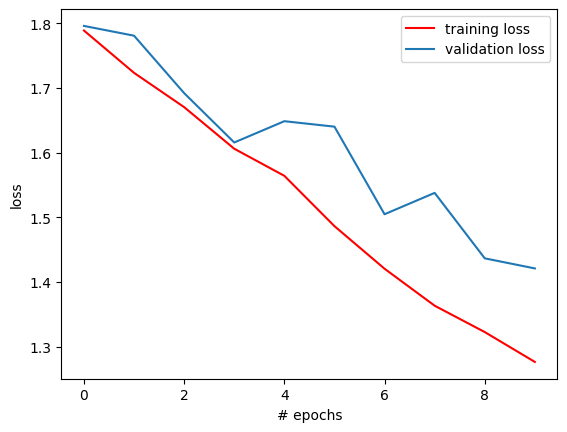

In [25]:
plt.plot(history_new_cnlst.history['loss'],'r',label='training loss')
plt.plot(history_new_cnlst.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Use pre-trained model for feature extraction (4 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

In [26]:
frames = seq_len
rows = img_height
columns = img_width

In [27]:
# Functional API
video = Input(shape=(seq_len,
                     img_height,
                     img_width,
                     n_channels))
cnn_base = VGG16(input_shape=(img_height,
                              img_width,
                              n_channels),
                 weights="imagenet",
                 include_top=False)
cnn_out = GlobalAveragePooling2D()(cnn_base.output)
cnn = Model(cnn_base.input, cnn_out)
cnn.trainable = False
encoded_frames = TimeDistributed(cnn)(video)
encoded_sequence = LSTM(256)(encoded_frames)
hidden_layer = Dense(1024, activation="relu")(encoded_sequence)
outputs = Dense(len(classes), activation="softmax")(hidden_layer)
model = Model([video], outputs)
optim = Adam(learning_rate=0.0002)
model.compile(loss="categorical_crossentropy",
              optimizer=optim,
              metrics=["accuracy"])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
vgg_history = model.fit(x= X, y=Y, validation_data=(Xtest, Ytest), batch_size=20, epochs=10)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3291 - loss: 1.6599 - val_accuracy: 0.5667 - val_loss: 1.2352
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7543 - loss: 1.0024 - val_accuracy: 0.6667 - val_loss: 0.9216
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8609 - loss: 0.5984 - val_accuracy: 0.6000 - val_loss: 0.8301
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9086 - loss: 0.4146 - val_accuracy: 0.6833 - val_loss: 0.7403
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9516 - loss: 0.2656 - val_accuracy: 0.6750 - val_loss: 0.7404
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9563 - loss: 0.1830 - val_accuracy: 0.7000 - val_loss: 0.7455
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9843 - loss: 0.1218 - val_accuracy: 0.6917 - val_loss: 0.7434
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9997 - loss: 0.0784 - val_accuracy: 0.6917 - val_loss:

**Adding Dropout to reduce ovefitting**

In [29]:
# Sequential API
cnn = Sequential()
cnn.add(VGG16(input_shape=(img_height, img_width, n_channels), weights="imagenet", include_top=False))
cnn.add(GlobalAveragePooling2D())
cnn.trainable = False
model = Sequential()
model.add(TimeDistributed(cnn))
model.add(LSTM(512))
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2048, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dense(len(classes), activation="softmax"))
optim = Adam(learning_rate=0.0002)
model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])

In [30]:
vgg_history = model.fit(x= X, y=Y, validation_data=(Xtest, Ytest), batch_size=20, epochs=10)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2871 - loss: 1.6735 - val_accuracy: 0.5333 - val_loss: 1.0220
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6306 - loss: 0.8731 - val_accuracy: 0.6333 - val_loss: 0.8827
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7256 - loss: 0.6368 - val_accuracy: 0.6833 - val_loss: 0.7621
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8396 - loss: 0.3892 - val_accuracy: 0.6667 - val_loss: 0.7010
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8985 - loss: 0.2760 - val_accuracy: 0.6667 - val_loss: 0.8587
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9187 - loss: 0.2224 - val_accuracy: 0.6750 - val_loss: 0.7581
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9143 - loss: 0.2026 - val_accuracy: 0.6583 - val_loss: 1.0220
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9386 - loss: 0.1602 - val_accuracy: 0.6583 - val_loss:

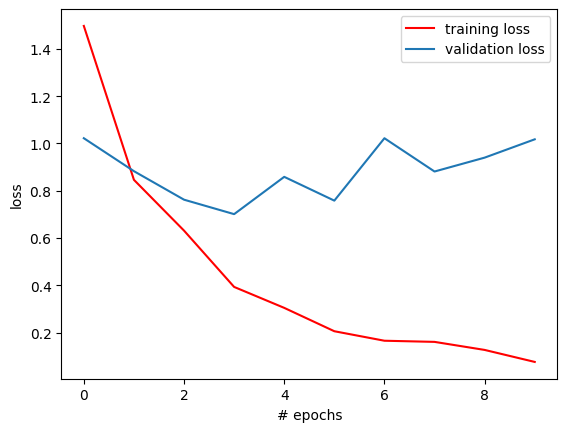

In [31]:
plt.plot(vgg_history.history['loss'],'r',label='training loss')
plt.plot(vgg_history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Reference reading:

[Image sequence training with video as input
](https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f)

### Report Analysis

* Report the video frames sequences used to classify the sequences correctly
* Discuss the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and convnet